In [18]:
from fforma.metrics import WeightedPinballLoss
from fforma.meta_learner import MetaLearnerNN
from fforma.meta_results_r_data import prepare_fforma_data

from ESRNN.m4_data import prepare_m4_data, seas_dict
from ESRNN.utils_evaluation import evaluate_prediction_owa

from fforma.utils import (
    FactorQuantileRegressionAveraging,
    LassoQuantileRegressionAveraging,
    evaluate_forecasts,
    freqs
)

import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X_train_df, preds_train_df, y_train_df, X_test_df, preds_test_df = prepare_fforma_data('data/hyndman_data',
                                                                                             dataset_name='Hourly')
#dataset_name=None for all data

Successfully decompressed  data/hyndman_data/raw/decompressed_data


In [3]:
dataset_name = 'Hourly'
directory = './data/'
h = seas_dict[dataset_name]['output_size']

df = preds_train_df.groupby(['unique_id']).size()
uids = df[df == h].index

preds_train_df = preds_train_df[preds_train_df['unique_id'].isin(uids)]
y_train_df = y_train_df[y_train_df['unique_id'].isin(uids)]
X_train_df = X_train_df[X_train_df['unique_id'].isin(uids)]

_, _, _, y_test_df = prepare_m4_data(dataset_name=dataset_name,
                                                      directory=directory,
                                                      num_obs=100_000)
y_test_df['ds'] = y_test_df[['unique_id','ds']].groupby('unique_id').cumcount()+1 

In [237]:
nn_params = {#'layers': [100, 100],
             'layers': [200, 100, 50, 25, 10],
             'dropout': 0.1,
             'epochs': 100,
             'batch_size': 8,
             'learning_rate': 0.001,
             'gradient_eps': 1e-8,
             'weight_decay': 0,
             'lr_scheduler_step_size': 200,
             'lr_decay': 0.1,
             'use_softmax':True,
             'loss_function': WeightedPinballLoss(0.20)}

In [238]:
model = MetaLearnerNN(nn_params)

In [239]:
model.fit(X_train_df, preds_train_df, y_train_df)

========= Epoch 0 finished =========
Training time: 0.27709
Training loss: 201.78465
========= Epoch 1 finished =========
Training time: 0.2565
Training loss: 148.90184
========= Epoch 2 finished =========
Training time: 0.26319
Training loss: 139.12791
========= Epoch 3 finished =========
Training time: 0.26813
Training loss: 131.34267
========= Epoch 4 finished =========
Training time: 0.27586
Training loss: 135.57785
========= Epoch 5 finished =========
Training time: 0.26288
Training loss: 119.23241
========= Epoch 6 finished =========
Training time: 0.25738
Training loss: 114.88205
========= Epoch 7 finished =========
Training time: 0.25624
Training loss: 113.34990
========= Epoch 8 finished =========
Training time: 0.27376
Training loss: 109.06248
========= Epoch 9 finished =========
Training time: 0.25936
Training loss: 108.39192
========= Epoch 10 finished =========
Training time: 0.25626
Training loss: 102.76036
========= Epoch 11 finished =========
Training time: 0.24772
Trai

========= Epoch 97 finished =========
Training time: 0.24613
Training loss: 69.56446
========= Epoch 98 finished =========
Training time: 0.2403
Training loss: 71.33980
========= Epoch 99 finished =========
Training time: 0.24305
Training loss: 70.02803


In [240]:
y_hat = model.predict(X_test_df, preds_test_df, y_test_df)

In [241]:
y_hat

,unique_id,ds,y,y_hat_naive2,y_hat
0,H1,1,619.0,620.173495,636.402100
1,H1,2,565.0,555.345593,569.781494
2,H1,3,532.0,510.350908,522.567139
3,H1,4,495.0,477.593160,489.573792
4,H1,5,481.0,456.282399,467.463013
...,...,...,...,...,...
19867,H99,44,24039.0,26592.763219,23836.195312
19868,H99,45,22946.0,25790.862983,22984.341797
19869,H99,46,22217.0,25293.883862,22417.667969
19870,H99,47,21416.0,24842.567612,21934.074219


In [242]:
# Plot
def plot_prediction(y, y_hat,ax):
    n_y = len(y)
    n_yhat = len(y_hat)
    ds_y = np.array(range(n_y))
    ds_yhat = np.array(range(n_y-n_yhat, n_y))

    ax.plot(ds_y, y, label = 'y')
    ax.plot(ds_yhat, y_hat, label='y_hat')
    
def plot_grid(x,n_row,n_col):
    n_graph = len(x)
    fig, axs = plt.subplots(n_row, n_col, figsize=(5*n_col, 3*n_row))
    plt.xticks(rotation=45)
    
    for i in range(n_graph):
        row = int(np.floor(i/n_col))
        col = i % n_col
        plot_prediction(y=x[i][0],y_hat=x[i][1], ax=axs[row, col])
        flag=1
    plt.show()

In [243]:
(y_hat['y']-y_hat['y_hat']).mean() #-151 -0.86 -0.57 -102 -81

-81.2954082219452

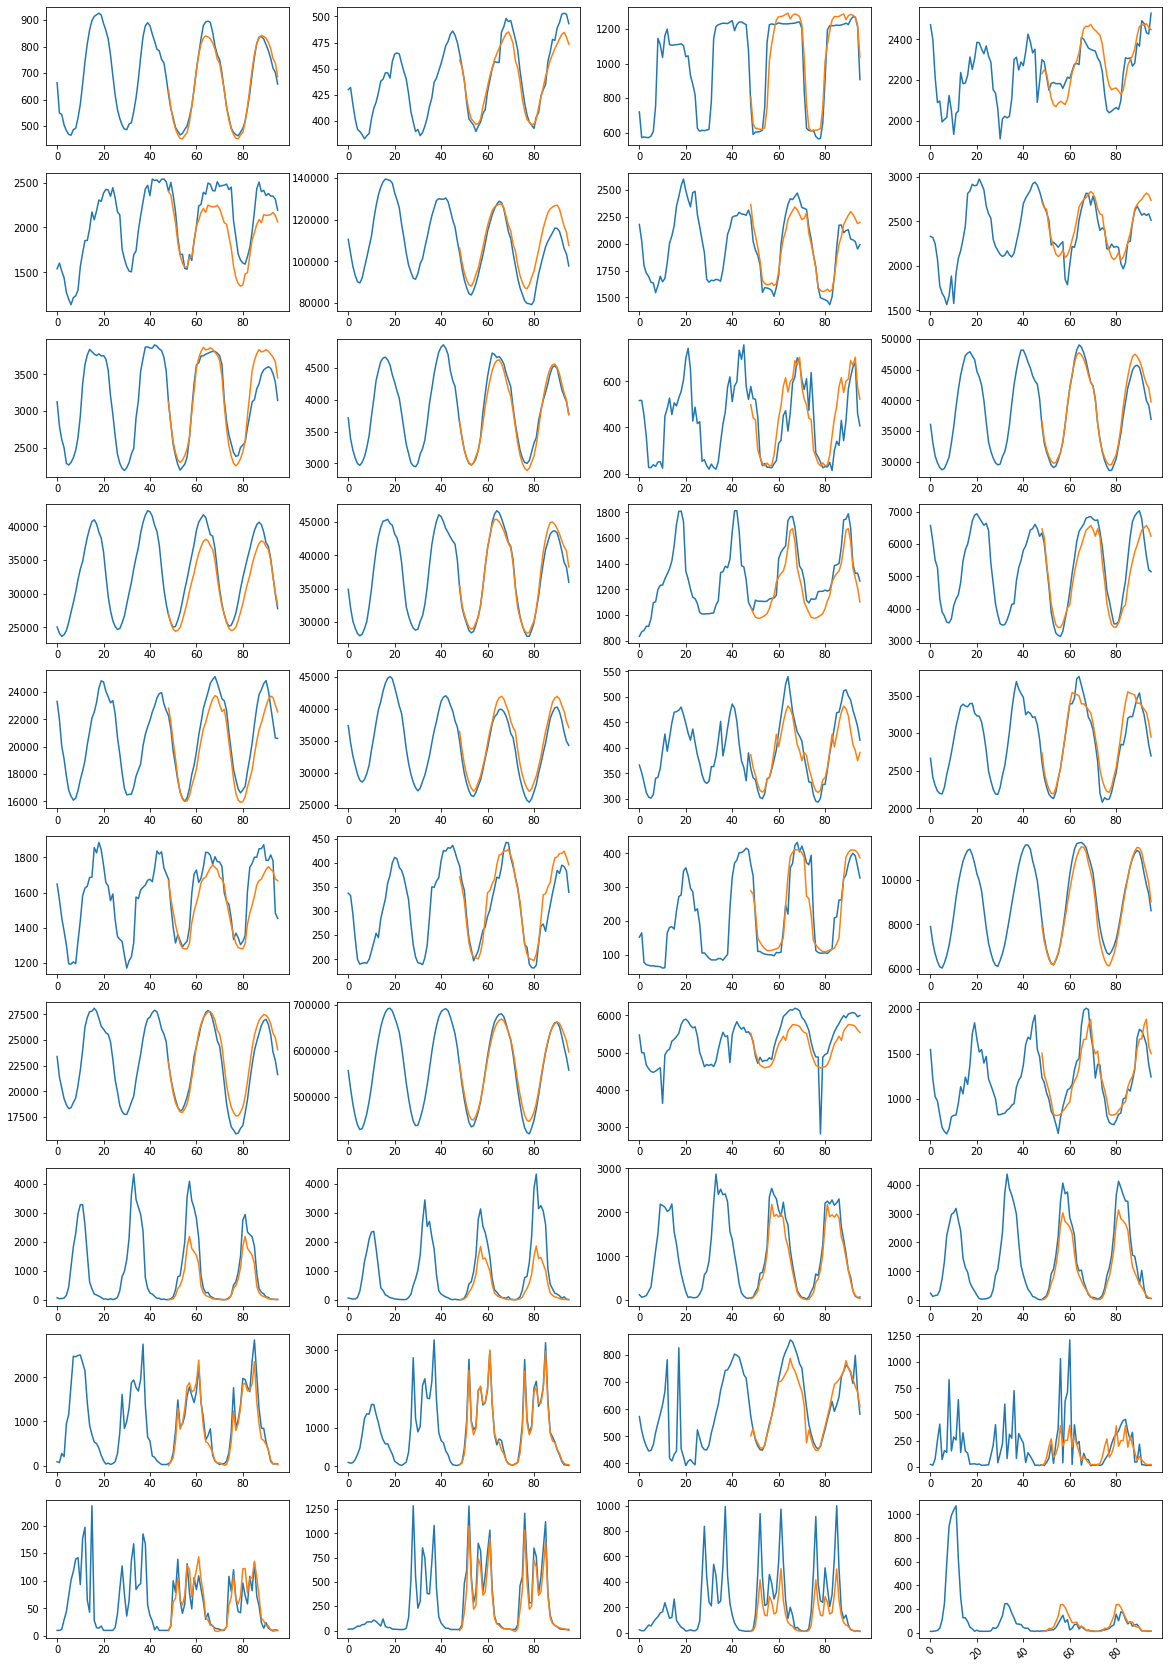

In [244]:
ids = y_hat['unique_id'].unique()
plots = []
for i in range(40):
    plot_id = ids[i]
    plot_df = y_hat[y_hat['unique_id']==plot_id]
    y_train = y_train_df[y_train_df['unique_id']==plot_id]
    y = np.concatenate([y_train['y'],plot_df['y']])
    plots.append((y, plot_df['y_hat']))

plot_grid(plots,10,4)